# (Generative adversary network) GAN - I’m Something of a Painter Myself
## Description of the problem

```
The chalenge is to train at least two neural networs a generative and a discriminator to recreate the Monet painting style.  
There are 4 directories monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg, the sufix jpg and tfrec stand for the type of files in each directory. 
My objective is to transform the photo images by adding the Monet style learned by the GAN in the process.

``` 


## Data description

In [1]:
from os import path, listdir
#from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import numpy as np
from os import mkdir
from shutil import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import time
import gan_helping_module as ghm
from datetime import datetime

path_to_monet_paintings = path.realpath('./data/monet_jpg/')
list_dir_monet = listdir(path=path_to_monet_paintings)
path_to_photo_jpg = path.realpath('./data/photo_jpg/')
list_dir_photo = listdir(path=path_to_photo_jpg)

In [2]:
display(Markdown(f'**Executive number of photos in the Monet folder: {len(list_dir_monet)}**'))

display(Markdown(f'**Executive number of photos in the photo folder: {len(list_dir_photo)}**'))


**Executive number of photos in the Monet folder: 300**

**Executive number of photos in the photo folder: 7038**

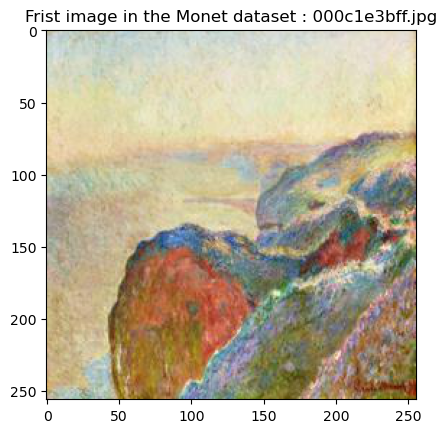

**Shape file: (256, 256, 3)**

In [3]:
one_image =  path.realpath(path.join(path_to_monet_paintings, list_dir_monet[0]))
im = Image.open(one_image)
im_np_array =  np.array(im)
plt.imshow(im_np_array)
plt.title('Frist image in the Monet dataset : %s' % list_dir_monet[0])
plt.show()
display(Markdown(f'**Shape file: {im_np_array.shape}**'))

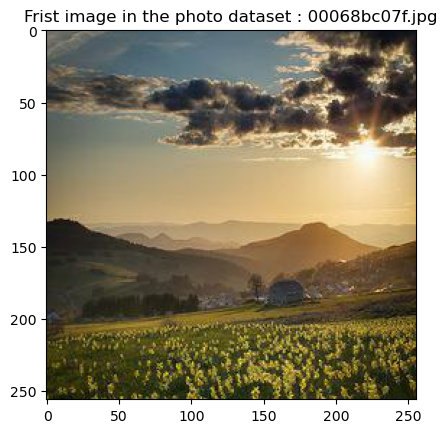

**Shape file: (256, 256, 3)**

In [4]:
one_image =  path.realpath(path.join(path_to_photo_jpg, list_dir_photo[0]))
im = Image.open(one_image)
im_np_array =  np.array(im)
plt.imshow(im_np_array)
plt.title('Frist image in the photo dataset : %s' % list_dir_photo[0])
plt.show()
display(Markdown(f'**Shape file: {im_np_array.shape}**'))

### Gernerative Adversary Networks implementation


I decided to test the Pix2Pix approach. This takes an input image and generates another one using some image sample.  You can find the approach in this website https://www.tensorflow.org/tutorials/generative/pix2pix.
The strategy is simple there is a generator and a discriminator and the generator tries to fool the generator producing an image similar to the target image. This algoritm has been proved to be very good translating satelite images to maps. 

The mayority of my work was preparing the inputs and creating a helping module in order to improve redability of the process



In [21]:
def get_concat_h(im1, im2):
    ## This function concatenate the images to train the alrotim.
    ## it pais to image the input image (real photo), and sample image(a Monet)
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [18]:
#### preparing the images
photo_subset = np.random.choice(list_dir_photo,size=300)
concat_path = './data/photo_concat'
if not path.exists(concat_path):
    
    mkdir(concat_path)
for i in range(len(list_dir_monet)):
    im1 = Image.open(path.join(path_to_monet_paintings, list_dir_monet[i]))
    im2 = Image.open(path.join(path_to_photo_jpg, photo_subset[i]))
    output_im  = get_concat_h(im1, im2)
    output_im.save(path.join(path.realpath(concat_path),list_dir_monet[i].split('.')[0]+'_'+photo_subset[i].split('.')[0] +'.jpg'))


concat_path = './data/photo_concat'
training_path = path.join('./data/photo_concat/','training')
validation_path = path.join('./data/photo_concat/','validation')
list_dir_format_im = listdir(concat_path)
if not path.exists(validation_path):
    mkdir(validation_path)
if not path.exists(training_path):
    mkdir(training_path)


train_monet, val_monet = train_test_split(list_dir_format_im, test_size=0.30, shuffle=True)

for im in train_monet:
    copy(path.join(concat_path,im), path.join(training_path,im))

for im in val_monet:
    copy(path.join(concat_path,im), path.join(validation_path,im))


In [3]:
training_path = path.join('./data/photo_concat/','training')
validation_path = path.join('./data/photo_concat/','validation')

train_dataset = tf.data.Dataset.list_files(path.join(training_path , '*.jpg'))
train_dataset = train_dataset.map(ghm.load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(ghm.BUFFER_SIZE)
train_dataset = train_dataset.batch(ghm.BATCH_SIZE)


In [4]:
test_dataset = tf.data.Dataset.list_files(path.join(validation_path , '*.jpg'))
test_dataset = test_dataset.map(ghm.load_image_test)
test_dataset = test_dataset.batch(ghm.BATCH_SIZE)

In [5]:
display(Markdown('# creating the generative model'))

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    ghm.downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    ghm.downsample(128, 4),  # (batch_size, 64, 64, 128)
    ghm.downsample(256, 4),  # (batch_size, 32, 32, 256)
    ghm.downsample(512, 4),  # (batch_size, 16, 16, 512)
    ghm.downsample(512, 4),  # (batch_size, 8, 8, 512)
    ghm.downsample(512, 4),  # (batch_size, 4, 4, 512)
    ghm.downsample(512, 4),  # (batch_size, 2, 2, 512)
    ghm.downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    ghm.upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    ghm.upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    ghm.upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    ghm.upsample(512, 4),  # (batch_size, 16, 16, 1024)
    ghm.upsample(256, 4),  # (batch_size, 32, 32, 512)
    ghm.upsample(128, 4),  # (batch_size, 64, 64, 256)
    ghm.upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(ghm.OUTPUT_CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')  # (batch_size, 256, 256, 3)
  x = inputs
  
  # Downsampling through the model
 
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


# creating the generative model

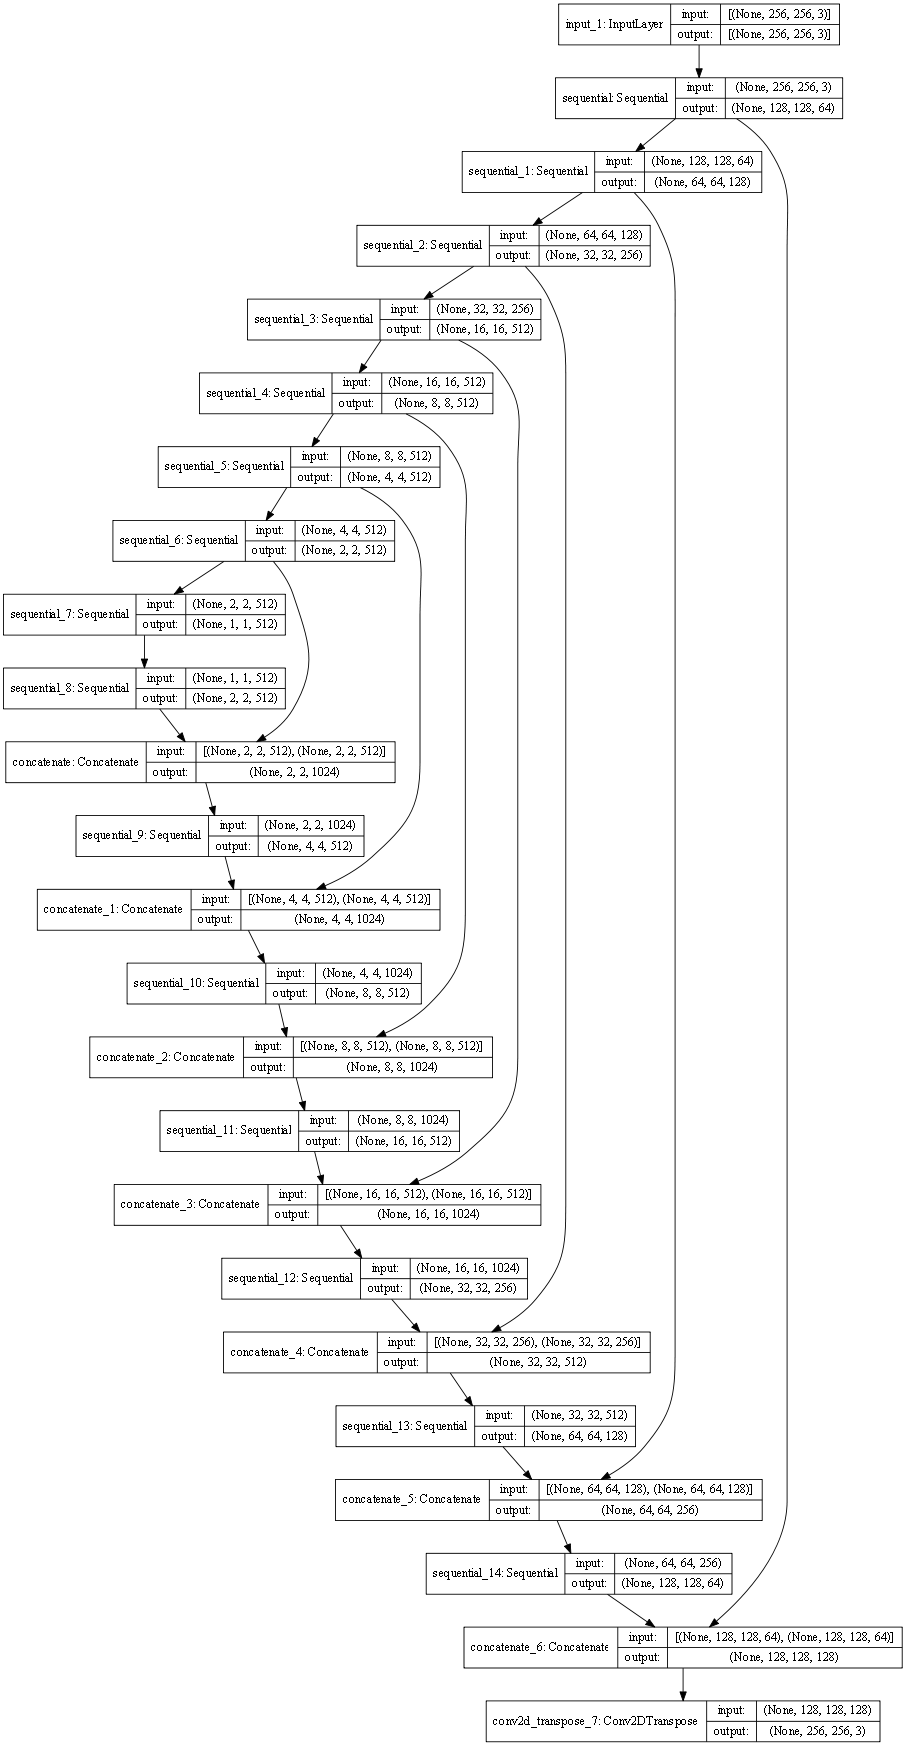

In [6]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


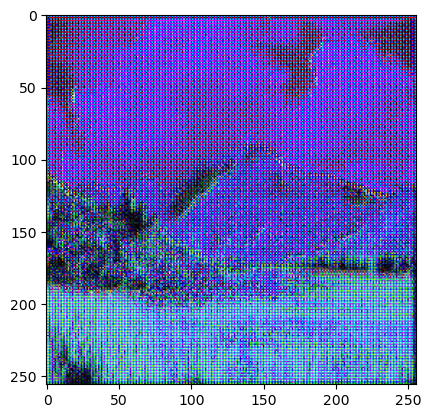

In [7]:
gen_output = generator(im_np_array[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])


In [8]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = ghm.downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = ghm.downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = ghm.downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


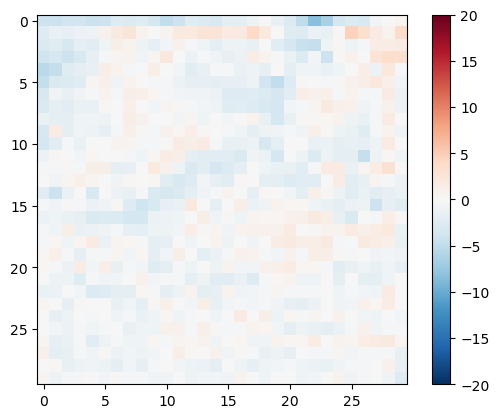

In [9]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)
disc_out = discriminator([im_np_array[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


In [10]:
log_dir="./logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))



In [11]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = ghm.generator_loss(disc_generated_output, gen_output, target)
    disc_loss = ghm.discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  ghm.generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  ghm.discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=ghm.generator_optimizer,
                                 discriminator_optimizer=ghm.discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [13]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


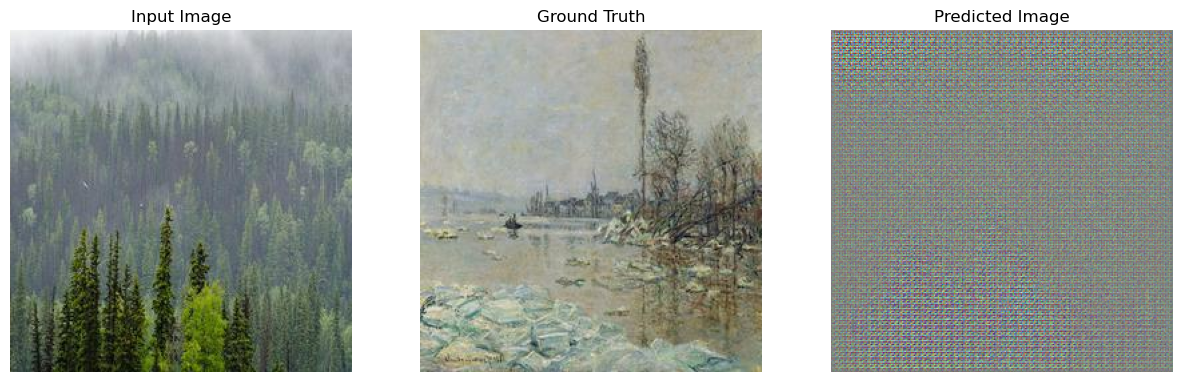

In [14]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)


In [18]:

def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [16]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}


Reusing TensorBoard on port 6006 (pid 36756), started 0:11:44 ago. (Use '!kill 36756' to kill it.)

Time taken for 1000 steps: 420.15 sec



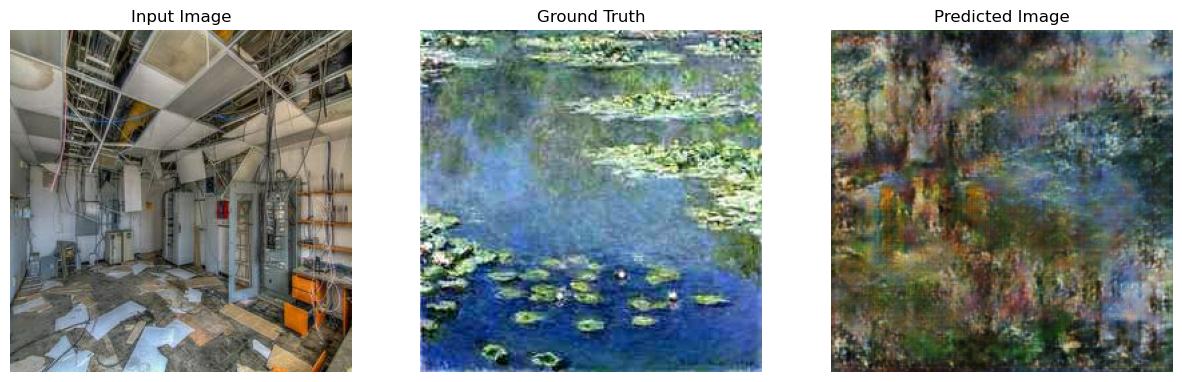

Step: 39k
....................................................................................................

In [19]:
fit(train_dataset, test_dataset, steps=40000)


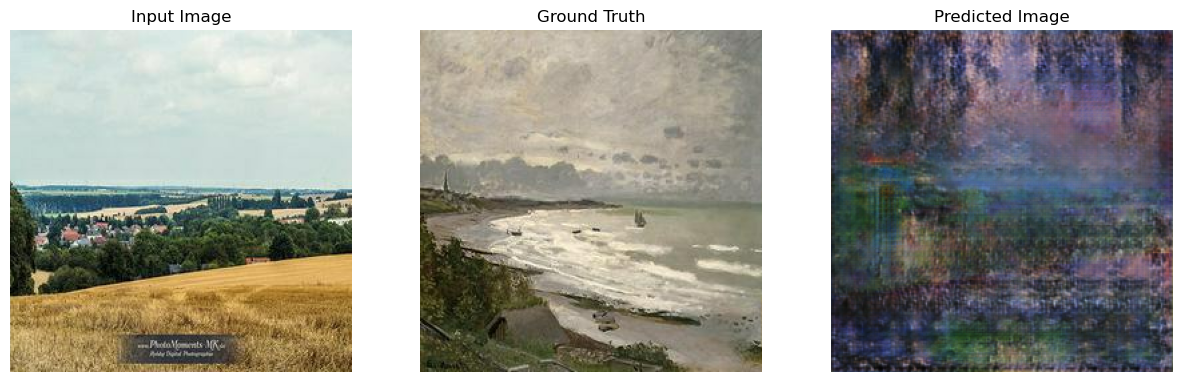

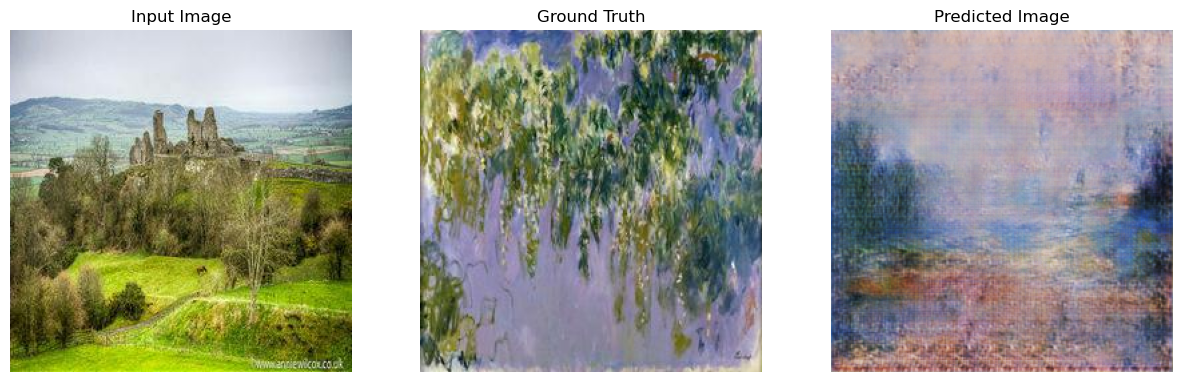

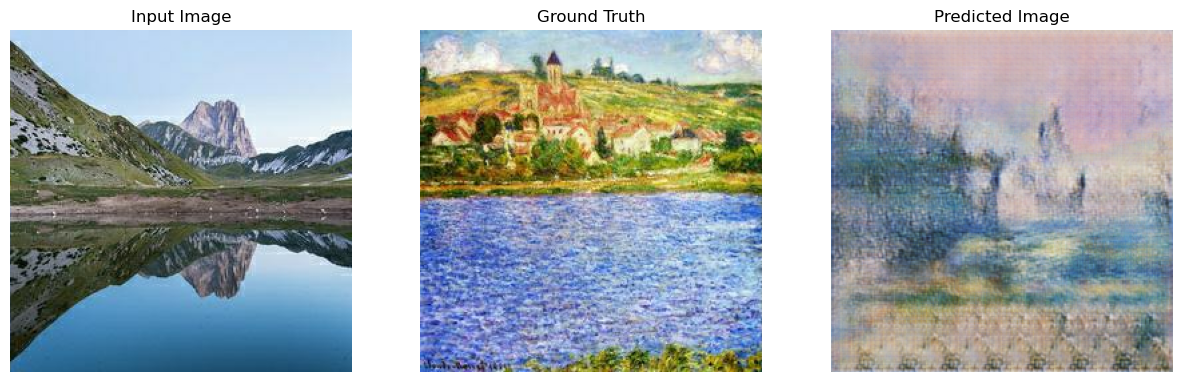

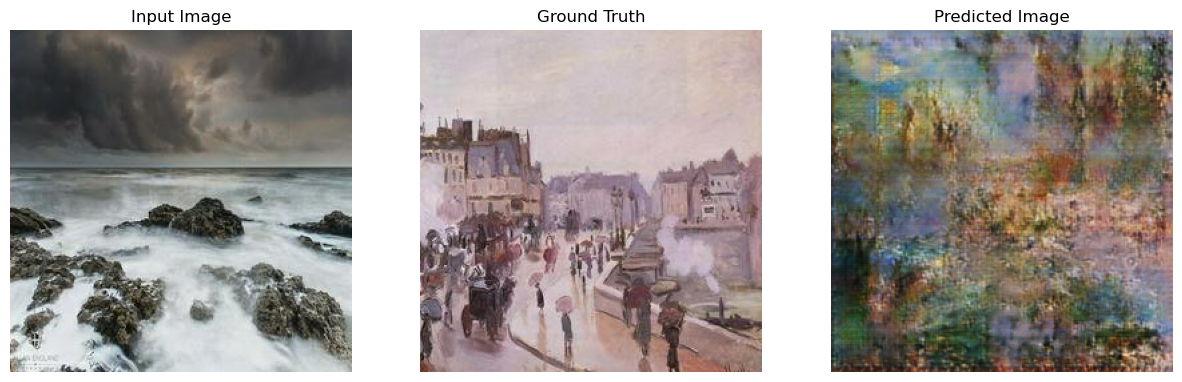

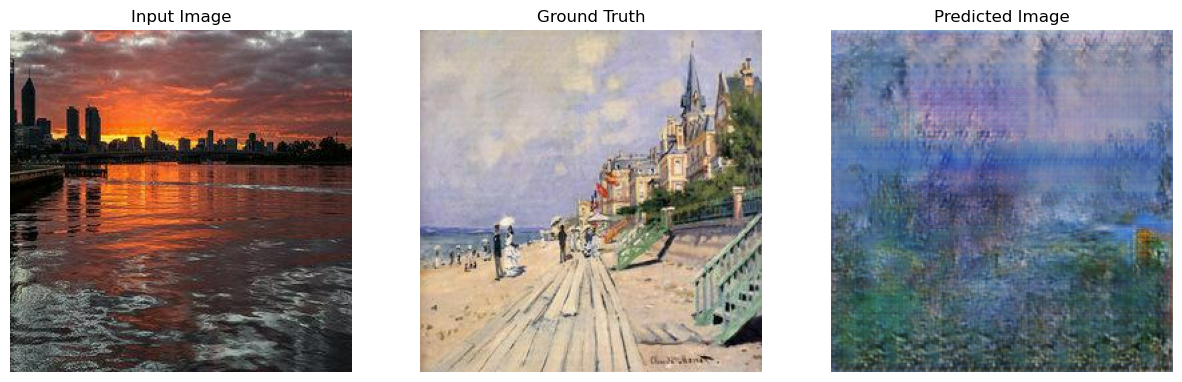

In [20]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [34]:
concat_path_1 = './data/photo_concat/for_im_generation'
if not path.exists(concat_path_1):
    mkdir(concat_path_1)

np.random.shuffle(list_dir_monet)
len_monet = len(list_dir_monet)

for i in range(len(list_dir_photo)):
    j = i % len_monet
    im1 = Image.open(path.join(path_to_monet_paintings, list_dir_monet[j]))
    im2 = Image.open(path.join(path_to_photo_jpg, list_dir_photo[i]))
    output_im  = get_concat_h(im1, im2)
    output_im.save(path.join(path.realpath(concat_path_1),list_dir_monet[j].split('.')[0]+'_'+list_dir_photo[i].split('.')[0] +'.jpg'))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [42]:

def generate_save_images(model, test_input, dirt2save, pic_name):
  prediction = model(test_input, training=True)
  dir_name = path.join(dirt2save,pic_name)
  tf.keras.utils.save_img(
    dir_name, prediction[0], data_format=None, file_format=None, scale=True
  )
  #image = Image(prediction)
  #image.save(dir_name)
  
prediction_dataset = tf.data.Dataset.list_files(path.join(concat_path_1 , '*.jpg'))
prediction_dataset = prediction_dataset.map(ghm.load_image_test)
prediction_dataset = prediction_dataset.batch(ghm.BATCH_SIZE)

predicted_path = './data/predicted_im'

if not path.exists(predicted_path):
  mkdir(predicted_path)
j = 1
for input, target in prediction_dataset:
  j = j+1
  generate_save_images(generator, input, predicted_path, 'pred_' + str(j) + '.jpg')

In [43]:
generator.save(path.realpath('./model'))

INFO:tensorflow:Assets written to: D:\Training_courses\generative_adversarial_networks\model\assets


### Analysis of the results

I trained the algorithm with one batch of 300 pair real image and Monet images. The result proved to be interesting with the colors Similar to the Monet, however the images are very abstract. I think that this result can be improved by training with a bigger pool of images, I would suggest to try first with 1000 and then add more if the result is not very good.




